## Model prep
### Resources: 
- https://towardsdatascience.com/text-preprocessing-steps-and-universal-pipeline-94233cb6725a

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import numpy as np
import seaborn as sns
import nltk
import tensorflow as tf
from sklearn.model_selection import train_test_split
import keras
nltk.download('stopwords')
import string


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/overlord/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
dataset = pd.read_csv(r'./data/humor-ai-data.csv')

In [3]:
dataset.head()

,body,rating,id
0,"A man visits the doctor. The doctor says ""I ha...",3,72a59c7b-fe42-4490-8297-5ac3c4b3486a
1,This couple had an excellent relationship goin...,3,f5ec106e-fa6d-4f97-81e6-2e78b9701832
2,Q. What's 200 feet long and has 4 teeth?A. The...,3,3be1e2ec-76cd-476e-b283-55cb2b7ef70a
3,Q. What's the difference between a man and a t...,3,f808f5a9-dd98-4732-bd01-6c995c75c1ed
4,Q.\tWhat's O. J. Simpson's Internet address?A....,3,b498eefe-5fb6-41e0-b616-03dbf82013ec


In [4]:
dataset['body'][120]

'A blonde is terribly overweight, so her doctor puts her on a diet. "I want you to eat regularly for 2 days, then skip a day, and repeat this procedure for 2 weeks. The next time I see you, you\'ll have lost at least 5 pounds." When the blonde returned, she shocked the doctor by losing nearly 20 pounds. "Why, that\'s amazing!" the doctor said, "Did you follow my instructions?" The blonde nodded, "I\'ll tell you though, I thought I was going to drop dead that 3rd day." "From hunger, you mean?", asked the doctor." "No, from all that skipping."'

### Exploring the dataset
Wee see a nice distribution of ratings, you can almost say it's well-blanced

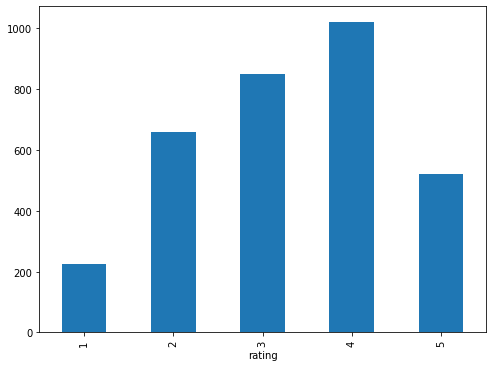

In [5]:

fig = plt.figure(figsize=(8,6))
dataset.groupby('rating').body.count().plot.bar()
plt.show()

### Assigning text labels to the ratings
Goes as follows:
1 == "terrible"
2 == "not good"
3 == "ok"
4 == "funny"
5 == "very funny"

In [6]:
# TODO: save new ratings as a new column
def tranform_rating(rating):
    if rating == 1:
        return "terrible"
    elif rating == 2:
        return "not good"
    elif rating == 3:
        return "ok"
    elif rating == 4:
        return "funny"
    elif rating == 5:
        return "very funny"


In [7]:
dataset['rating_text'] = dataset['rating'].apply(tranform_rating)

In [8]:
dataset.head()

,body,rating,id,rating_text
0,"A man visits the doctor. The doctor says ""I ha...",3,72a59c7b-fe42-4490-8297-5ac3c4b3486a,ok
1,This couple had an excellent relationship goin...,3,f5ec106e-fa6d-4f97-81e6-2e78b9701832,ok
2,Q. What's 200 feet long and has 4 teeth?A. The...,3,3be1e2ec-76cd-476e-b283-55cb2b7ef70a,ok
3,Q. What's the difference between a man and a t...,3,f808f5a9-dd98-4732-bd01-6c995c75c1ed,ok
4,Q.\tWhat's O. J. Simpson's Internet address?A....,3,b498eefe-5fb6-41e0-b616-03dbf82013ec,ok


### Text processing with Spacy

In [9]:
# Stolen from https://github.com/slaps-lab/bibliotheca/blob/master/text/expand_contractions_with_spacy.ipynb
def expand_contractions(text: str) -> str:
    
    ## https://en.wikipedia.org/wiki/Wikipedia:List_of_English_contractions
    
    flags = re.IGNORECASE | re.MULTILINE
    
    text = re.sub(r'`', "'", text, flags = flags)
    
    ## starts / ends with '
    text = re.sub(
        r"(\s|^)'(aight|cause)(\s|$)",
        '\g<1>\g<2>\g<3>',
        text, flags = flags
    )
    
    text = re.sub(
        r"(\s|^)'t(was|is)(\s|$)", r'\g<1>it \g<2>\g<3>',
        text,
        flags = flags
    )
    
    text = re.sub(
        r"(\s|^)ol'(\s|$)",
        '\g<1>old\g<2>',
        text, flags = flags
    )
    
    ## expand words without '
    text = re.sub(r"\b(aight)\b", 'alright', text, flags = flags)
    text = re.sub(r'\bcause\b', 'because', text, flags = flags)
    text = re.sub(r'\b(finna|gonna)\b', 'going to', text, flags = flags)
    text = re.sub(r'\bgimme\b', 'give me', text, flags = flags)
    text = re.sub(r"\bgive'n\b", 'given', text, flags = flags)
    text = re.sub(r"\bhowdy\b", 'how do you do', text, flags = flags)
    text = re.sub(r"\bgotta\b", 'got to', text, flags = flags)
    text = re.sub(r"\binnit\b", 'is it not', text, flags = flags)
    text = re.sub(r"\b(can)(not)\b", r'\g<1> \g<2>', text, flags = flags)
    text = re.sub(r"\bwanna\b", 'want to', text, flags = flags)
    text = re.sub(r"\bmethinks\b", 'me thinks', text, flags = flags)
    
    ## one offs,
    text = re.sub(r"\bo'er\b", r'over', text, flags = flags)
    text = re.sub(r"\bne'er\b", r'never', text, flags = flags)
    text = re.sub(r"\bo'?clock\b", 'of the clock', text, flags = flags)
    text = re.sub(r"\bma'am\b", 'madam', text, flags = flags)
    text = re.sub(r"\bgiv'n\b", 'given', text, flags = flags)
    text = re.sub(r"\be'er\b", 'ever', text, flags = flags)
    text = re.sub(r"\bd'ye\b", 'do you', text, flags = flags)
    text = re.sub(r"\be'er\b", 'ever', text, flags = flags)
    text = re.sub(r"\bd'ye\b", 'do you', text, flags = flags)
    text = re.sub(r"\bg'?day\b", 'good day', text, flags = flags)
    text = re.sub(r"\b(ain|amn)'?t\b", 'am not', text, flags = flags)
    text = re.sub(r"\b(are|can)'?t\b", r'\g<1> not', text, flags = flags)
    text = re.sub(r"\b(let)'?s\b", r'\g<1> us', text, flags = flags)
    
    ## major expansions involving smaller,
    text = re.sub(r"\by'all'dn't've'd\b", 'you all would not have had', text, flags = flags)
    text = re.sub(r"\by'all're\b", 'you all are', text, flags = flags)
    text = re.sub(r"\by'all'd've\b", 'you all would have', text, flags = flags)
    text = re.sub(r"(\s)y'all(\s)", r'\g<1>you all\g<2>', text, flags = flags)
    
    ## minor,
    text = re.sub(r"\b(won)'?t\b", 'will not', text, flags = flags)
    text = re.sub(r"\bhe'd\b", 'he had', text, flags = flags)

    ## major,
    text = re.sub(r"\b(I|we|who)'?d'?ve\b", r'\g<1> would have', text, flags = flags)
    text = re.sub(r"\b(could|would|must|should|would)n'?t'?ve\b", r'\g<1> not have', text, flags = flags)
    text = re.sub(r"\b(he)'?dn'?t'?ve'?d\b", r'\g<1> would not have had', text, flags = flags)
    text = re.sub(r"\b(daren|daresn|dasn)'?t", 'dare not', text, flags = flags)
    text = re.sub(r"\b(he|how|i|it|she|that|there|these|they|we|what|where|which|who|you)'?ll\b", r'\g<1> will', text, flags = flags)
    text = re.sub(r"\b(everybody|everyone|he|how|it|she|somebody|someone|something|that|there|this|what|when|where|which|who|why)'?s\b", r'\g<1> is', text, flags = flags)
    text = re.sub(r"\b(I)'?m'a\b", r'\g<1> am about to', text, flags = flags)
    text = re.sub(r"\b(I)'?m'o\b", r'\g<1> am going to', text, flags = flags)
    text = re.sub(r"\b(I)'?m\b", r'\g<1> am', text, flags = flags)
    text = re.sub(r"\bshan't\b", 'shall not', text, flags = flags)
    text = re.sub(r"\b(are|could|did|does|do|go|had|has|have|is|may|might|must|need|ought|shall|should|was|were|would)n'?t\b", r'\g<1> not', text, flags = flags)
    text = re.sub(r"\b(could|had|he|i|may|might|must|should|these|they|those|to|we|what|where|which|who|would|you)'?ve\b", r'\g<1> have', text, flags = flags)
    text = re.sub(r"\b(how|so|that|there|these|they|those|we|what|where|which|who|why|you)'?re\b", r'\g<1> are', text, flags = flags)
    text = re.sub(r"\b(I|it|she|that|there|they|we|which|you)'?d\b", r'\g<1> had', text, flags = flags)
    text = re.sub(r"\b(how|what|where|who|why)'?d\b", r'\g<1> did', text, flags = flags)
    
    return text



In [10]:
def to_dict(lst):
    dict = {lst[i]: lst[i] for i in range(0, len(lst))}
    return dict

sentence_ends = ['.', '?', '!', ',', ':']
sent_end_dict = to_dict(sentence_ends)

for char in sentence_ends:
    sent_end_dict[char] = char + " "

sent_end_dict

{'.': '. ', '?': '? ', '!': '! ', ',': ', ', ':': ': '}

In [11]:
def clean_text(text):
    # Expand contractions
    text = expand_contractions(text)

    # Add " " after sentence end & chars specified in sent_end_dict
    table = str.maketrans(sent_end_dict)
    text = text.translate(table)

    # Lowercase
    # text = text.lower()

    # Remove punctuation
    table = str.maketrans(' ', ' ', string.punctuation)
    text = text.translate(table)

    # Remove non-alpha chars
    text = ' '.join(word for word in text.split() if word.isalpha())

    return text

In [12]:
import spacy

In [13]:
nlp = spacy.load("en_core_web_sm", disable=['ner', 'lemmatizer'])

In [14]:
from spacy.language import Language
from spacy.tokens import Doc

@Language.factory("custom_cleaner")
def create_cleaner_component(nlp: Language, name: str):
    return CleanerComponent(nlp)

class CleanerComponent:
    def __init__(self, nlp: Language):
        self.nlp = nlp

    def __call__(self, doc: Doc) -> Doc:
        text = doc.text
        return self.nlp.make_doc(clean_text(text))

In [15]:
nlp.pipeline

[('tok2vec', <spacy.pipeline.tok2vec.Tok2Vec at 0x7f2ff28bb270>),
 ('tagger', <spacy.pipeline.tagger.Tagger at 0x7f2ff1e91860>),
 ('parser', <spacy.pipeline.dep_parser.DependencyParser at 0x7f2ff1e5b400>),
 ('attribute_ruler',
  <spacy.pipeline.attributeruler.AttributeRuler at 0x7f2ff1eaef40>)]

In [16]:

nlp.add_pipe("custom_cleaner", before = 'tok2vec')
nlp.pipeline



[('custom_cleaner', <__main__.CleanerComponent at 0x7f2ff0dfb2b0>),
 ('tok2vec', <spacy.pipeline.tok2vec.Tok2Vec at 0x7f2ff28bb270>),
 ('tagger', <spacy.pipeline.tagger.Tagger at 0x7f2ff1e91860>),
 ('parser', <spacy.pipeline.dep_parser.DependencyParser at 0x7f2ff1e5b400>),
 ('attribute_ruler',
  <spacy.pipeline.attributeruler.AttributeRuler at 0x7f2ff1eaef40>)]

In [17]:
clean_body = []

# Ryzen 4500U 6-core beast power
for doc in nlp.pipe(dataset['body'], batch_size=500):
    if doc.has_annotation("DEP"):
        arr = [str(n.text) for n in doc]
        joke = ' '.join(arr)
        clean_body.append(joke)
    else:
        clean_body.append(None)

dataset['body'] = clean_body

In [18]:
dataset['body'][120]

'A blonde is terribly overweight so her doctor puts her on a diet I want you to eat regularly for days then skip a day and repeat this procedure for weeks The next time I see you you will have lost at least pounds When the blonde returned she shocked the doctor by losing nearly pounds Why that is amazing the doctor said Did you follow my instructions The blonde nodded I will tell you though I thought I was going to drop dead that day From hunger you mean asked the doctor No from all that skipping'

In [19]:
train_cleaned = dataset['body']
train_cleaned

0       A man visits the doctor The doctor says I have...
1       This couple had an excellent relationship goin...
2       Q What is feet long and has teeth A The front ...
3       Q What is the difference between a man and a t...
4       Q What is O J Simpsons Internet address A Slas...
                              ...                        
3269    Britain decided it was time to switch left lan...
3270    Examples of unclear writing Sentences taken fr...
3271    The Pope and the Queen of England are on the s...
3272    Letter to Xerox and the Reply Dear Kings of Ko...
3273    Note Tradewars is on online roleplaying game w...
Name: body, Length: 3274, dtype: object

In [40]:
train_vec = []
for doc in nlp.pipe(train_cleaned, batch_size=500, n_process=6):
    if doc.has_vector:
        train_vec.append(doc.vector)
    # If doc doesn't have a vector, then fill it with zeros.
    else:
        train_vec.append(np.zeros((96,), dtype="float32"))
        
train_vec = np.array(train_vec)


In [41]:
train_vec.shape

(3274, 96)

In [42]:
from sklearn.preprocessing import label_binarize

# Transform labels into one hot encoded format.
y_train_ohe = label_binarize(dataset['rating_text'], classes=['terrible', 'not good', 'ok', 'funny', 'very funny'])
print('y_train_ohe shape: {}'.format(y_train_ohe.shape))
print('y_train_ohe samples:')
print(y_train_ohe[:5])



y_train_ohe shape: (3274, 5)
y_train_ohe samples:
[[0 0 1 0 0]
 [0 0 1 0 0]
 [0 0 1 0 0]
 [0 0 1 0 0]
 [0 0 1 0 0]]


In [43]:
from sklearn.model_selection import train_test_split

# If using spaCy word vectors
X_train, X_test, y_train, y_test = train_test_split(train_vec, y_train_ohe, test_size=0.2, random_state=21)

print('X_train size: {}'.format(X_train.shape))
print('X_test size: {}'.format(X_test.shape))
print('y_train size: {}'.format(y_train.shape))
print('y_test size: {}'.format(y_test.shape))

X_train size: (2619, 96)
X_test size: (655, 96)
y_train size: (2619, 5)
y_test size: (655, 5)


In [44]:
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Input, LSTM, Embedding, Bidirectional, Flatten
from keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D
from keras.optimizers import SGD

def build_model():
    model = Sequential()
    # Densely Connected Neural Network (Multi-Layer Perceptron)
    model.add(Dense(512, activation='relu', kernel_initializer='he_normal', input_dim=96))
    model.add(Dropout(0.2))
    model.add(Dense(512, activation='relu', kernel_initializer='he_normal'))
    model.add(Dropout(0.2))
    model.add(Dense(512, activation='relu', kernel_initializer='he_normal'))
    model.add(Dropout(0.2))
    model.add(Dense(512, activation='relu', kernel_initializer='he_normal'))
    model.add(Dropout(0.2))
    model.add(Dense(5, activation='softmax'))
    return model

In [45]:
model = build_model()
# Compile the model
sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['acc'])

In [46]:
# Define number of epochs
epochs = 100

# Fit the model to the training data
estimator = model.fit(X_train, y_train,
                      validation_split=0.2,
                      epochs=epochs, batch_size=128, verbose=1, shuffle=True)

Epoch 1/100
17/17 [==============================] - 1s 20ms/step - loss: 1.6004 - acc: 0.2877 - val_loss: 1.5184 - val_acc: 0.2920
Epoch 2/100
17/17 [==============================] - 0s 12ms/step - loss: 1.5527 - acc: 0.2713 - val_loss: 1.5202 - val_acc: 0.2920
Epoch 3/100
17/17 [==============================] - 0s 11ms/step - loss: 1.5228 - acc: 0.3034 - val_loss: 1.5148 - val_acc: 0.2939
Epoch 4/100
17/17 [==============================] - 0s 11ms/step - loss: 1.5146 - acc: 0.3239 - val_loss: 1.5126 - val_acc: 0.2939
Epoch 5/100
17/17 [==============================] - 0s 12ms/step - loss: 1.5229 - acc: 0.3136 - val_loss: 1.5084 - val_acc: 0.2939
Epoch 6/100
17/17 [==============================] - 0s 11ms/step - loss: 1.5193 - acc: 0.2902 - val_loss: 1.5108 - val_acc: 0.2844
Epoch 7/100
17/17 [==============================] - 0s 11ms/step - loss: 1.5180 - acc: 0.3097 - val_loss: 1.5098 - val_acc: 0.2863
Epoch 8/100
17/17 [==============================] - 0s 11ms/step - loss: 1.

In [47]:
print("Training accuracy: %.2f%% / Validation accuracy: %.2f%%" % 
      (100*estimator.history['acc'][-1], 100*estimator.history['val_acc'][-1]))

Training accuracy: 66.78% / Validation accuracy: 25.57%


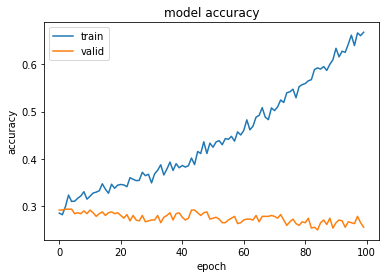

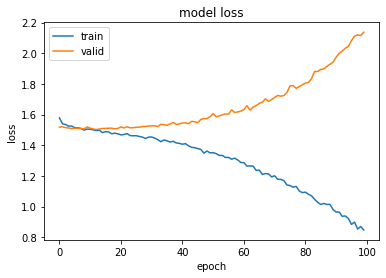

In [48]:
# Plot model accuracy over epochs
sns.reset_orig()   # Reset seaborn settings to get rid of black background
plt.plot(estimator.history['acc'])
plt.plot(estimator.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

# Plot model loss over epochs
plt.plot(estimator.history['loss'])
plt.plot(estimator.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

In [37]:
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(dataset['body'])
sequences = tokenizer.texts_to_sequences(dataset['body'])
one_hot_results = tokenizer.texts_to_matrix(dataset['body'], mode='binary')

word_index = tokenizer.word_index
print('Found {} unique tokens.'.format(len(word_index)))

Found 19113 unique tokens.


In [41]:
sequences[0]

[2,
 29,
 2611,
 1,
 115,
 1,
 115,
 35,
 6,
 22,
 230,
 252,
 18,
 5,
 5,
 22,
 2949,
 3,
 5335,
 1438,
 1,
 29,
 122,
 17,
 20,
 601,
 123,
 6,
 25,
 13,
 22,
 2949]

In [40]:
len(dataset['body'][0])

157

In [188]:
one_hot_results[0]

array([0., 0., 1., ..., 0., 0., 0.])

In [ ]:
# Skip one hot encoding
# Add word embeddings
# Hyperparam=MAX_LENGTH. Calc median length, set it as max
# Notebook 7.1 - inspiration for generation. Translate into word-by-word generation
# Hyperparam=TEMP. Test in practise. From 1.0

In [21]:
clean_body_short = clean_body[:1500]

In [22]:
len(clean_body_short)

1500

In [20]:


# keras module for building LSTM 
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding, LSTM, Dense, Dropout
from keras.preprocessing.text import Tokenizer
from keras.callbacks import EarlyStopping
from keras.models import Sequential
import keras.utils as ku

import pandas as pd
import numpy as np
import string, os 

import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)



In [21]:
tokenizer = Tokenizer()

def get_sequence_of_tokens(corpus):
    ## tokenization
    tokenizer.fit_on_texts(corpus)
    total_words = len(tokenizer.word_index) + 1
    
    ## convert data to sequence of tokens 
    input_sequences = []
    for line in corpus:
        token_list = tokenizer.texts_to_sequences([line])[0]
        for i in range(1, len(token_list)):
            n_gram_sequence = token_list[:i+1]
            input_sequences.append(n_gram_sequence)
    return input_sequences, total_words

inp_sequences, total_words = get_sequence_of_tokens(clean_body_short)
inp_sequences[:10]

[[2, 26],
 [2, 26, 1352],
 [2, 26, 1352, 1],
 [2, 26, 1352, 1, 109],
 [2, 26, 1352, 1, 109, 1],
 [2, 26, 1352, 1, 109, 1, 109],
 [2, 26, 1352, 1, 109, 1, 109, 25],
 [2, 26, 1352, 1, 109, 1, 109, 25, 6],
 [2, 26, 1352, 1, 109, 1, 109, 25, 6, 30],
 [2, 26, 1352, 1, 109, 1, 109, 25, 6, 30, 283]]

In [22]:
def generate_padded_sequences(input_sequences):
    max_sequence_len = max([len(x) for x in input_sequences])
    input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))
    
    predictors, label = input_sequences[:,:-1],input_sequences[:,-1]
    label = ku.to_categorical(label, num_classes=total_words)
    return predictors, label, max_sequence_len

predictors, label, max_sequence_len = generate_padded_sequences(inp_sequences)

In [23]:
def create_model(max_sequence_len, total_words):
    input_len = max_sequence_len - 1
    model = Sequential()
    
    # Add Input Embedding Layer
    model.add(Embedding(total_words, 10, input_length=input_len))
    
    # Add Hidden Layer 1 - LSTM Layer
    model.add(LSTM(100))
    model.add(Dropout(0.1))
    
    # Add Output Layer
    model.add(Dense(total_words, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam')
    
    return model

model = create_model(max_sequence_len, total_words)
model.summary()



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 576, 10)           50450     
_________________________________________________________________
lstm (LSTM)                  (None, 100)               44400     
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 5045)              509545    
Total params: 604,395
Trainable params: 604,395
Non-trainable params: 0
_________________________________________________________________


In [24]:
model.fit(predictors, label, epochs=5)

Epoch 1/5
1476/1476 [==============================] - 371s 251ms/step - loss: 6.6617
Epoch 2/5
1476/1476 [==============================] - 372s 252ms/step - loss: 6.0615
Epoch 3/5
1476/1476 [==============================] - 358s 243ms/step - loss: 5.8457
Epoch 4/5
1476/1476 [==============================] - 352s 238ms/step - loss: 5.6209
Epoch 5/5
1476/1476 [==============================] - 373s 253ms/step - loss: 5.3819


In [25]:
loss, accuracy = model.evaluate(x=predictors, y=label)

1476/1476 [==============================] - 91s 61ms/step - loss: 5.1093


TypeError: cannot unpack non-iterable float object

In [26]:
def generate_text(seed_text, next_words, model, max_sequence_len):
    for _ in range(next_words):
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
        predicted = model.predict_classes(token_list, verbose=0)
        
        output_word = ""
        for word,index in tokenizer.word_index.items():
            if index == predicted:
                output_word = word
                break
        seed_text += " "+output_word
    return seed_text.title()

In [29]:
print (generate_text("", 25, model, max_sequence_len))

Sun Was A Brunette And A Brunette And A Brunette And A Brunette And A Brunette And A Brunette And A Brunette And A Brunette And


In [23]:
with open("humor-ai-body-small.txt", "w") as txt_file:
    for line in clean_body_short:
        txt_file.write(" ".join(line) + " ")


In [25]:

# Small LSTM Network to Generate Text for Alice in Wonderland
import numpy
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
from keras.callbacks import ModelCheckpoint
from keras.utils import np_utils


In [26]:
# load ascii text and covert to lowercase
filename = "humor-ai-body-small.txt"
raw_text = open(filename, 'r', encoding='utf-8').read()
raw_text = raw_text.lower()


In [27]:
# create mapping of unique chars to integers
chars = sorted(list(set(raw_text)))
char_to_int = dict((c, i) for i, c in enumerate(chars))
# summarize the loaded data
n_chars = len(raw_text)
n_vocab = len(chars)
print("Total Characters: ", n_chars)
print("Total Vocab: ", n_vocab)

Total Characters:  2234282
Total Vocab:  28


In [28]:
# prepare the dataset of input to output pairs encoded as integers
seq_length = 100
dataX = []
dataY = []
for i in range(0, n_chars - seq_length, 1):
	seq_in = raw_text[i:i + seq_length]
	seq_out = raw_text[i + seq_length]
	dataX.append([char_to_int[char] for char in seq_in])
	dataY.append(char_to_int[seq_out])
n_patterns = len(dataX)
print("Total Patterns: ", n_patterns)


Total Patterns:  2234182


In [29]:
# reshape X to be [samples, time steps, features]
X = numpy.reshape(dataX, (n_patterns, seq_length, 1))
# normalize
X = X / float(n_vocab)
# one hot encode the output variable
y = np_utils.to_categorical(dataY)


In [30]:
# define the LSTM model
model = Sequential()
model.add(LSTM(256, input_shape=(X.shape[1], X.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(y.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam')


In [31]:
# define the checkpoint
filepath="weights-improvement-{epoch:02d}-{loss:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]


In [32]:
# fit the model
model.fit(X, y, epochs=20, batch_size=128, callbacks=callbacks_list)

Epoch 1/20
   37/17455 [..............................] - ETA: 1:50:19 - loss: 2.5401